In [11]:
import pandas as pd

# Load datasets
claims_df = pd.read_csv("/home/mubasshir/Desktop/Research/Insurance/Dataset/archive/Train-1542865627584.csv")
beneficiary_df = pd.read_csv("/home/mubasshir/Desktop/Research/Insurance/Dataset/archive/Train_Beneficiarydata-1542865627584.csv")
inpatient_df = pd.read_csv("/home/mubasshir/Desktop/Research/Insurance/Dataset/archive/Train_Inpatientdata-1542865627584.csv")
outpatient_df = pd.read_csv("/home/mubasshir/Desktop/Research/Insurance/Dataset/archive/Train_Outpatientdata-1542865627584.csv")

# Convert date columns to datetime
inpatient_df["ClaimStartDt"] = pd.to_datetime(inpatient_df["ClaimStartDt"])
inpatient_df["ClaimEndDt"] = pd.to_datetime(inpatient_df["ClaimEndDt"])
outpatient_df["ClaimStartDt"] = pd.to_datetime(outpatient_df["ClaimStartDt"])
outpatient_df["ClaimEndDt"] = pd.to_datetime(outpatient_df["ClaimEndDt"])

# Add claim duration in days
inpatient_df["ClaimDuration"] = (inpatient_df["ClaimEndDt"] - inpatient_df["ClaimStartDt"]).dt.days
outpatient_df["ClaimDuration"] = (outpatient_df["ClaimEndDt"] - outpatient_df["ClaimStartDt"]).dt.days

# Inpatient aggregation per beneficiary
inpatient_agg = inpatient_df.groupby("BeneID").agg(
    IP_TotalClaims=("ClaimID", "count"),
    IP_TotalReimbursed=("InscClaimAmtReimbursed", "sum"),
    IP_AvgDeductible=("DeductibleAmtPaid", "mean"),
    IP_UniqueProviders=("Provider", "nunique"),
    IP_AvgClaimDuration=("ClaimDuration", "mean")
).reset_index()

# Outpatient aggregation per beneficiary
outpatient_agg = outpatient_df.groupby("BeneID").agg(
    OP_TotalClaims=("ClaimID", "count"),
    OP_TotalReimbursed=("InscClaimAmtReimbursed", "sum"),
    OP_AvgDeductible=("DeductibleAmtPaid", "mean"),
    OP_UniqueProviders=("Provider", "nunique"),
    OP_AvgClaimDuration=("ClaimDuration", "mean")
).reset_index()

# Merge with beneficiary demographics and chronic conditions
beneficiary_full = beneficiary_df.merge(inpatient_agg, on="BeneID", how="left")
beneficiary_full = beneficiary_full.merge(outpatient_agg, on="BeneID", how="left")

# Fill NA with 0 for beneficiaries without claims
beneficiary_full.fillna(0, inplace=True)

In [12]:
# Combine inpatient and outpatient to map BeneID → Provider
claims_all = pd.concat([inpatient_df[["BeneID", "Provider"]],
                        outpatient_df[["BeneID", "Provider"]]])

# Drop duplicates: one provider per beneficiary (majority or latest can be chosen if many)
bene_provider_map = claims_all.drop_duplicates("BeneID")

# Merge with fraud labels
bene_provider_map = bene_provider_map.merge(claims_df, on="Provider", how="left")

# Merge into full beneficiary data
beneficiary_labeled = beneficiary_full.merge(bene_provider_map, on="BeneID", how="inner")

# Encode target variable
beneficiary_labeled["PotentialFraud"] = beneficiary_labeled["PotentialFraud"].map({"Yes": 1, "No": 0})

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Select features (drop ID columns and labels)
X = beneficiary_labeled.drop(columns=["BeneID", "Provider", "PotentialFraud", "DOB", "DOD", "RenalDiseaseIndicator"])
y = beneficiary_labeled["PotentialFraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75     24766
           1       0.64      0.44      0.52     16801

    accuracy                           0.67     41567
   macro avg       0.66      0.63      0.63     41567
weighted avg       0.67      0.67      0.66     41567



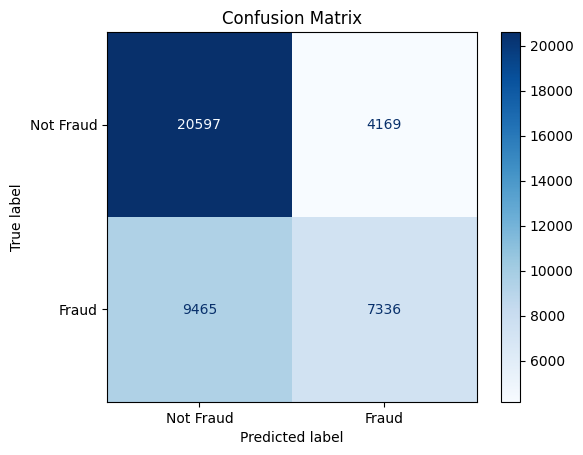

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.75     24766
           1       0.64      0.44      0.52     16801

    accuracy                           0.67     41567
   macro avg       0.66      0.63      0.63     41567
weighted avg       0.67      0.67      0.66     41567

ROC AUC Score: 0.7060


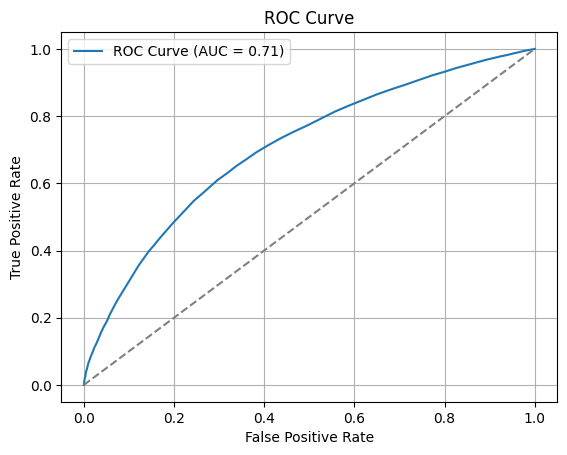

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")  # <--- This prints: ROC AUC Score: 0.9475 (example)


plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


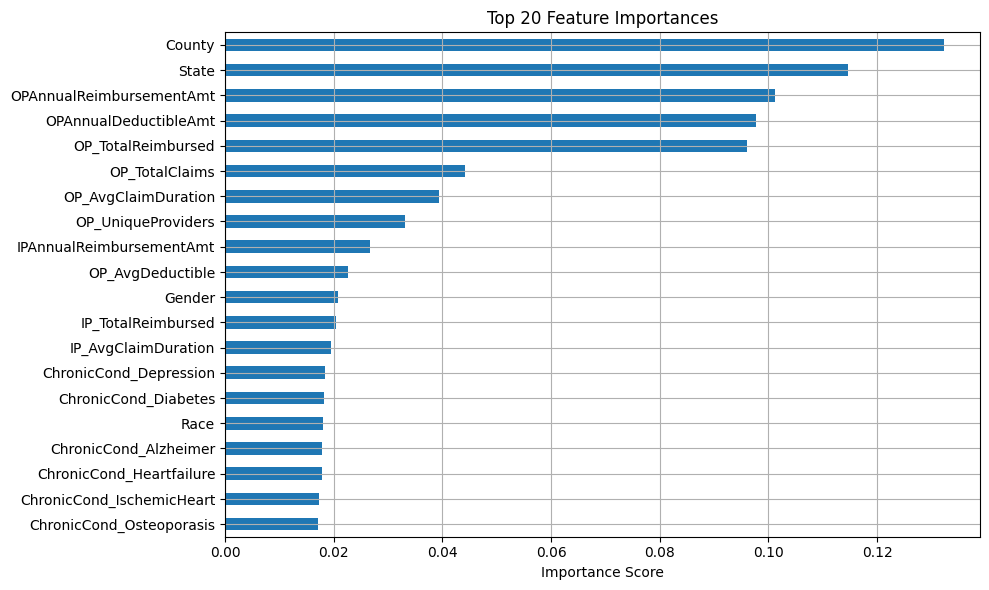

In [15]:
importances = clf.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_importance.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()
